In [47]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import os
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'dense121_finetune_last50.h5')

In [49]:
import os

correct_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray'
print(os.listdir(correct_path))


['val', 'test', 'train']


In [50]:
print("Train folders:", os.listdir(correct_path + '/train'))
print("Val folders:", os.listdir(correct_path + '/val'))
print("Test folders:", os.listdir(correct_path + '/test'))

Train folders: ['PNEUMONIA', 'NORMAL']
Val folders: ['NORMAL', 'PNEUMONIA']
Test folders: ['NORMAL', 'PNEUMONIA']


In [51]:
import glob
import os

for file in glob.glob(correct_path + '/**/.DS_Store', recursive=True):
    os.remove(file)


In [52]:
print(os.listdir(correct_path + '/train'))

['PNEUMONIA', 'NORMAL']


In [53]:
import os

val_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray/val'

print("VAL subfolders:", os.listdir(val_path))
print("NORMAL images:", len(os.listdir(os.path.join(val_path, 'NORMAL'))))
print("PNEUMONIA images:", len(os.listdir(os.path.join(val_path, 'PNEUMONIA'))))

VAL subfolders: ['NORMAL', 'PNEUMONIA']
NORMAL images: 8
PNEUMONIA images: 8


In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with 20% validation split
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training generator (80%)
train_gen = data_gen.flow_from_directory(
    '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator (20%)
val_gen = data_gen.flow_from_directory(
    '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 4175 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [55]:
print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)

Train samples: 4175
Validation samples: 1043


In [56]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Input shape must match your images
input_tensor = Input(shape=(224, 224, 3))  # 3 channels for RGB

# Load pretrained DenseNet121, excluding the top classifier
base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_tensor)

# ✅ Unfreeze only the last 50 layers of the base model
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # For binary classification

# Define final model
model = Model(inputs=base_model.input, outputs=output)


In [57]:
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [58]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [59]:
# ✅ 5. Data Augmentation + Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_gen = data_gen.flow_from_directory(
    '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = data_gen.flow_from_directory(
    '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 4175 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [60]:
# ✅ 6. Compute Class Weights
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [61]:
# ✅ 7. Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)


In [63]:

# ✅ 8. Train the Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_callback, early_stop, reduce_lr]
)

Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7600 - loss: 0.5421
Epoch 1: val_accuracy improved from -inf to 0.87536, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1017s 8s/step - accuracy: 0.7604 - loss: 0.5414 - val_accuracy: 0.8754 - val_loss: 0.3650 - learning_rate: 1.0000e-05
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8827 - loss: 0.3043
Epoch 2: val_accuracy improved from 0.87536 to 0.90316, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1027s 8s/step - accuracy: 0.8828 - loss: 0.3041 - val_accuracy: 0.9032 - val_loss: 0.2552 - learning_rate: 1.0000e-05
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9051 - loss: 0.2362
Epoch 3: val_accuracy improved from 0.90316 to 0.91371, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1103s 8s/step - accuracy: 0.9051 - loss: 0.2362 - val_accuracy: 0.9137 - val_loss: 0.2206 - learning_rate: 1.0000e-05
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9181 - loss: 0.2040
Epoch 4: val_accuracy improved from 0.91371 to 0.92042, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1064s 8s/step - accuracy: 0.9182 - loss: 0.2039 - val_accuracy: 0.9204 - val_loss: 0.2002 - learning_rate: 1.0000e-05
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9311 - loss: 0.1730
Epoch 5: val_accuracy improved from 0.92042 to 0.93001, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1045s 8s/step - accuracy: 0.9311 - loss: 0.1729 - val_accuracy: 0.9300 - val_loss: 0.1738 - learning_rate: 1.0000e-05
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9406 - loss: 0.1623
Epoch 6: val_accuracy improved from 0.93001 to 0.94343, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1052s 8s/step - accuracy: 0.9407 - loss: 0.1623 - val_accuracy: 0.9434 - val_loss: 0.1499 - learning_rate: 1.0000e-05
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9464 - loss: 0.1314
Epoch 7: val_accuracy did not improve from 0.94343
131/131 ━━━━━━━━━━━━━━━━━━━━ 1053s 8s/step - accuracy: 0.9464 - loss: 0.1315 - val_accuracy: 0.9415 - val_loss: 0.1522 - learning_rate: 1.0000e-05
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9480 - loss: 0.1373
Epoch 8: val_accuracy improved from 0.94343 to 0.95398, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1111s 8s/step - accuracy: 0.9480 - loss: 0.1372 - val_accuracy: 0.9540 - val_loss: 0.1268 - learning_rate: 1.0000e-05
Epoch 9/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9546 - loss: 0.1323
Epoch 9: val_accuracy did not improve from 0.95398
131/131 ━━━━━━━━━━━━━━━━━━━━ 1037s 8s/step - accuracy: 0.9546 - loss: 0.1322 - val_accuracy: 0.9415 - val_loss: 0.1440 - learning_rate: 1.0000e-05
Epoch 10/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9476 - loss: 0.1210
Epoch 10: val_accuracy improved from 0.95398 to 0.95973, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1060s 8s/step - accuracy: 0.9476 - loss: 0.1209 - val_accuracy: 0.9597 - val_loss: 0.1157 - learning_rate: 1.0000e-05
Epoch 11/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9584 - loss: 0.1102
Epoch 11: val_accuracy did not improve from 0.95973
131/131 ━━━━━━━━━━━━━━━━━━━━ 1093s 8s/step - accuracy: 0.9584 - loss: 0.1102 - val_accuracy: 0.9569 - val_loss: 0.1209 - learning_rate: 1.0000e-05
Epoch 12/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9666 - loss: 0.0962
Epoch 12: val_accuracy improved from 0.95973 to 0.96357, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1030s 8s/step - accuracy: 0.9666 - loss: 0.0962 - val_accuracy: 0.9636 - val_loss: 0.1060 - learning_rate: 1.0000e-05
Epoch 13/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9541 - loss: 0.1149
Epoch 13: val_accuracy did not improve from 0.96357
131/131 ━━━━━━━━━━━━━━━━━━━━ 1042s 8s/step - accuracy: 0.9541 - loss: 0.1148 - val_accuracy: 0.9559 - val_loss: 0.1139 - learning_rate: 1.0000e-05
Epoch 14/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9581 - loss: 0.0994
Epoch 14: val_accuracy improved from 0.96357 to 0.97028, saving model to /content/drive/MyDrive/model_checkpoints/dense121_finetune_last50.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1040s 8s/step - accuracy: 0.9582 - loss: 0.0994 - val_accuracy: 0.9703 - val_loss: 0.0948 - learning_rate: 1.0000e-05
Epoch 15/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9642 - loss: 0.0895
Epoch 15: val_accuracy did not improve from 0.97028
131/131 ━━━━━━━━━━━━━━━━━━━━ 1058s 8s/step - accuracy: 0.9642 - loss: 0.0895 - val_accuracy: 0.9674 - val_loss: 0.0854 - learning_rate: 1.0000e-05


model.save('/content/drive/MyDrive/final_dense121_aug_weighted_last50.h5')

In [64]:
model.save('/content/drive/MyDrive/final_dense121_aug_weighted_last50.h5')

In [65]:
import pickle

# Save history
with open('/content/drive/MyDrive/history_dense121.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [66]:
import os

test_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray/test'

# List class subfolders
print("Test set classes:", os.listdir(test_path))

# Count images in each class
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        print(f"{class_name}: {num_images} images")

Test set classes: ['NORMAL', 'PNEUMONIA']
NORMAL: 234 images
PNEUMONIA: 390 images


In [67]:
model = load_model('/content/drive/MyDrive/final_dense121_aug_weighted_last50.h5')


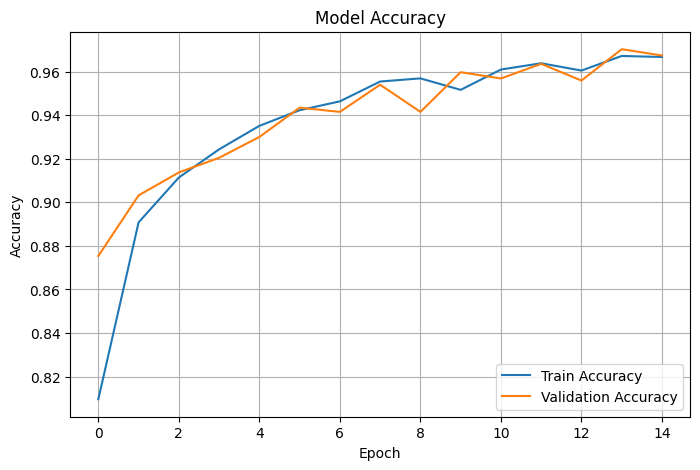

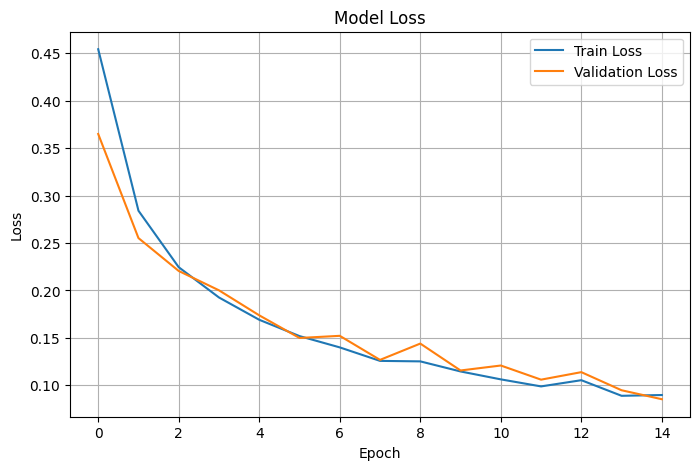

In [68]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [69]:
test_gen = data_gen.flow_from_directory(
    '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray/test',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Evaluate model
test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.7793 - loss: 0.5484
✅ Test Accuracy: 0.8750, Test Loss: 0.3325


In [70]:
import numpy as np

# Predict probabilities
y_probs = model.predict(test_gen)

# Convert probabilities to class predictions (0 or 1)
y_pred = (y_probs > 0.5).astype(int).reshape(-1)

# True labels from generator
y_true = test_gen.classes


20/20 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step


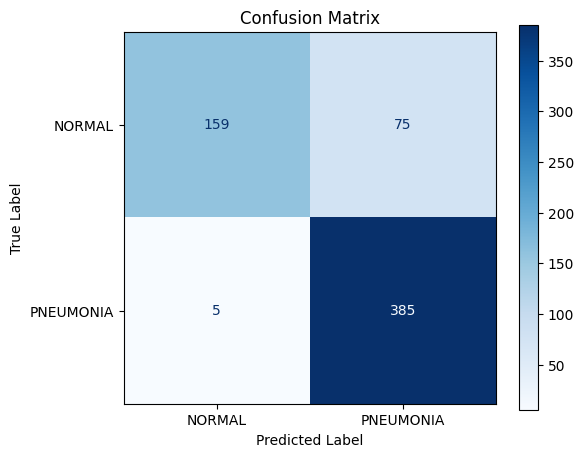

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true class labels
class_names = list(test_gen.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 119s 6s/step


<Figure size 600x500 with 0 Axes>

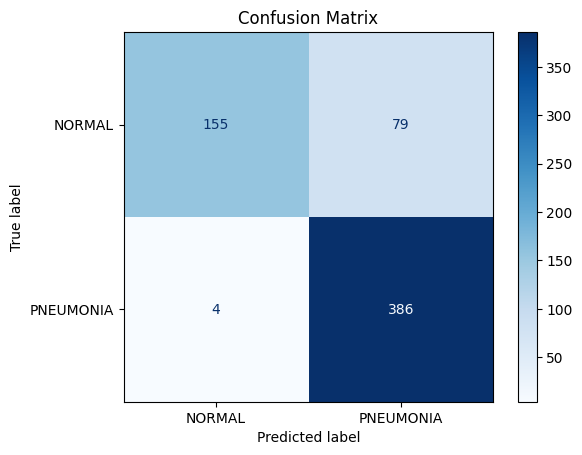

🔢 Confusion Matrix Counts:
True Positives (TP): 386
True Negatives (TN): 155
False Positives (FP): 79
False Negatives (FN): 4

📊 Performance Metrics:
Accuracy    : 0.8670
Precision   : 0.8301
Recall      : 0.9897
Specificity : 0.6624
F1 Score    : 0.9029

📈 Training Summary (Last Epoch):
Training Accuracy   : 0.9667
Validation Accuracy : 0.9674


In [72]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Predict on test set
y_probs = model.predict(test_gen)
y_true = test_gen.classes

# ✅ Use default threshold = 0.5 (or replace with optimal_threshold if found)
y_pred = (y_probs > 0.5).astype(int).reshape(-1)

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()

# ✅ Print confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ✅ Classification Metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)

print("🔢 Confusion Matrix Counts:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

print("\n📊 Performance Metrics:")
print(f"Accuracy    : {accuracy:.4f}")
print(f"Precision   : {precision:.4f}")
print(f"Recall      : {recall:.4f}")
print(f"Specificity : {specificity:.4f}")
print(f"F1 Score    : {f1:.4f}")

# ✅ Print Training History Summary
last_epoch = len(history.history['accuracy']) - 1
train_acc = history.history['accuracy'][last_epoch]
val_acc = history.history['val_accuracy'][last_epoch]

print("\n📈 Training Summary (Last Epoch):")
print(f"Training Accuracy   : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step

🔧 Optimal Threshold = 0.8963


<Figure size 600x500 with 0 Axes>

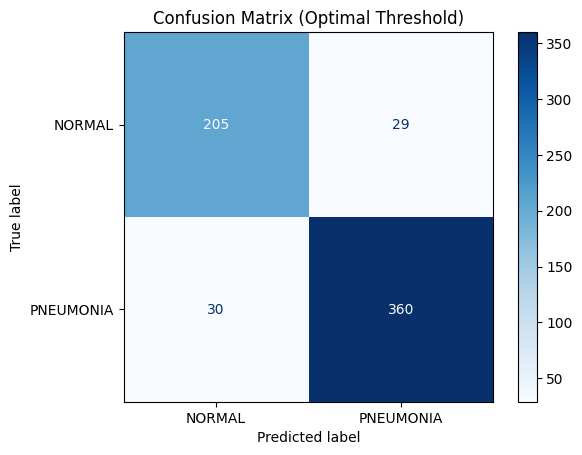

🔢 Confusion Matrix Counts:
True Positives (TP): 360
True Negatives (TN): 205
False Positives (FP): 29
False Negatives (FN): 30

📊 Performance Metrics (Optimal Threshold):
Accuracy    : 0.9054
Precision   : 0.9254
Recall      : 0.9231
Specificity : 0.8761
F1 Score    : 0.9243

📈 Training Summary (Last Epoch):
Training Accuracy   : 0.9667
Validation Accuracy : 0.9674


In [73]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# ✅ Predict probabilities
y_probs = model.predict(test_gen)
y_true = test_gen.classes

# ✅ 1. Find Optimal Threshold using Youden’s Index
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
print(f"\n🔧 Optimal Threshold = {optimal_threshold:.4f}")

# ✅ 2. Apply optimal threshold
y_pred_opt = (y_probs > optimal_threshold).astype(int).reshape(-1)

# ✅ 3. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_opt)
TN, FP, FN, TP = cm.ravel()

# ✅ 4. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Optimal Threshold)")
plt.grid(False)
plt.show()

# ✅ 5. Compute evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)

# ✅ 6. Print metrics
print("🔢 Confusion Matrix Counts:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

print("\n📊 Performance Metrics (Optimal Threshold):")
print(f"Accuracy    : {accuracy:.4f}")
print(f"Precision   : {precision:.4f}")
print(f"Recall      : {recall:.4f}")
print(f"Specificity : {specificity:.4f}")
print(f"F1 Score    : {f1:.4f}")

# ✅ 7. Print Training History Summary
last_epoch = len(history.history['accuracy']) - 1
train_acc = history.history['accuracy'][last_epoch]
val_acc = history.history['val_accuracy'][last_epoch]

print("\n📈 Training Summary (Last Epoch):")
print(f"Training Accuracy   : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")


In [75]:
# Re-run this in Colab and let me know
y_probs = model.predict(test_gen)
y_true = test_gen.classes
filepaths = test_gen.filepaths  # For locating misclassified images


20/20 ━━━━━━━━━━━━━━━━━━━━ 114s 6s/step


20/20 ━━━━━━━━━━━━━━━━━━━━ 114s 6s/step

🔧 Optimal Threshold = 0.9584


<Figure size 600x500 with 0 Axes>

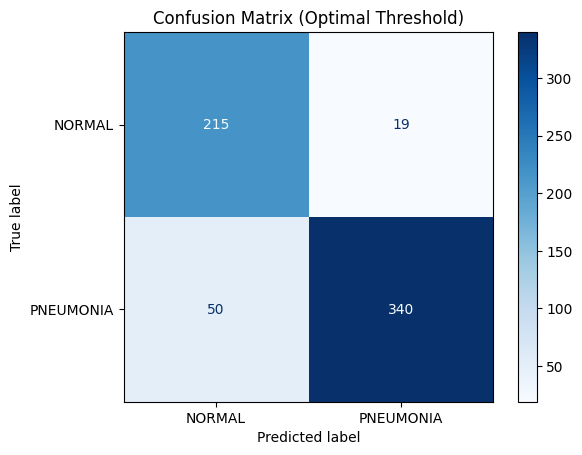

🔢 Confusion Matrix Counts:
True Positives (TP): 340
True Negatives (TN): 215
False Positives (FP): 19
False Negatives (FN): 50

📊 Performance Metrics (Optimal Threshold):
Accuracy    : 0.8894
Precision   : 0.9471
Recall      : 0.8718
Specificity : 0.9188
F1 Score    : 0.9079

📈 Training Summary (Last Epoch):
Training Accuracy   : 0.9667
Validation Accuracy : 0.9674


In [76]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# ✅ Predict probabilities
y_probs = model.predict(test_gen)
y_true = test_gen.classes

# ✅ 1. Find Optimal Threshold using Youden’s Index
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
print(f"\n🔧 Optimal Threshold = {optimal_threshold:.4f}")

# ✅ 2. Apply optimal threshold
y_pred_opt = (y_probs > optimal_threshold).astype(int).reshape(-1)

# ✅ 3. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_opt)
TN, FP, FN, TP = cm.ravel()

# ✅ 4. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Optimal Threshold)")
plt.grid(False)
plt.show()

# ✅ 5. Compute evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)

# ✅ 6. Print metrics
print("🔢 Confusion Matrix Counts:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

print("\n📊 Performance Metrics (Optimal Threshold):")
print(f"Accuracy    : {accuracy:.4f}")
print(f"Precision   : {precision:.4f}")
print(f"Recall      : {recall:.4f}")
print(f"Specificity : {specificity:.4f}")
print(f"F1 Score    : {f1:.4f}")

# ✅ 7. Print Training History Summary
last_epoch = len(history.history['accuracy']) - 1
train_acc = history.history['accuracy'][last_epoch]
val_acc = history.history['val_accuracy'][last_epoch]

print("\n📈 Training Summary (Last Epoch):")
print(f"Training Accuracy   : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step

🔧 Using Fixed Threshold = 0.90


<Figure size 600x500 with 0 Axes>

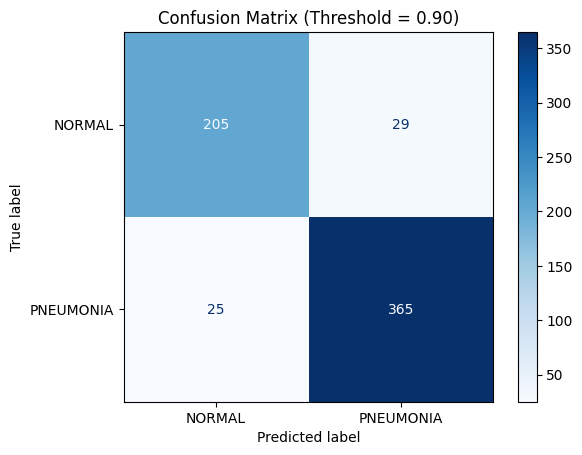

🔢 Confusion Matrix Counts:
True Positives (TP): 365
True Negatives (TN): 205
False Positives (FP): 29
False Negatives (FN): 25

📊 Performance Metrics (Threshold = 0.90):
Accuracy    : 0.9135
Precision   : 0.9264
Recall      : 0.9359
Specificity : 0.8761
F1 Score    : 0.9311
AUC         : 0.9616

📈 Training Summary (Last Epoch):
Training Accuracy   : 0.9667
Validation Accuracy : 0.9674


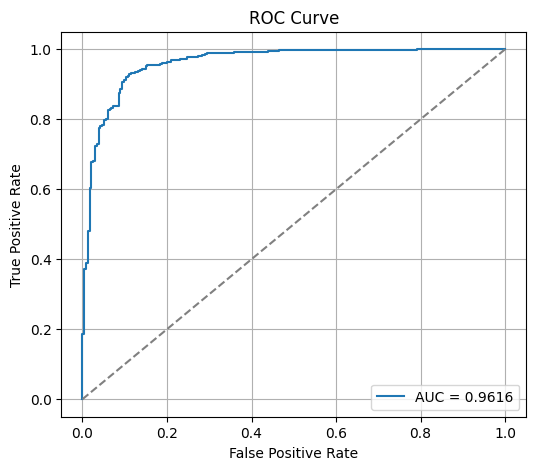


🖼️ Showing 12 misclassified images:


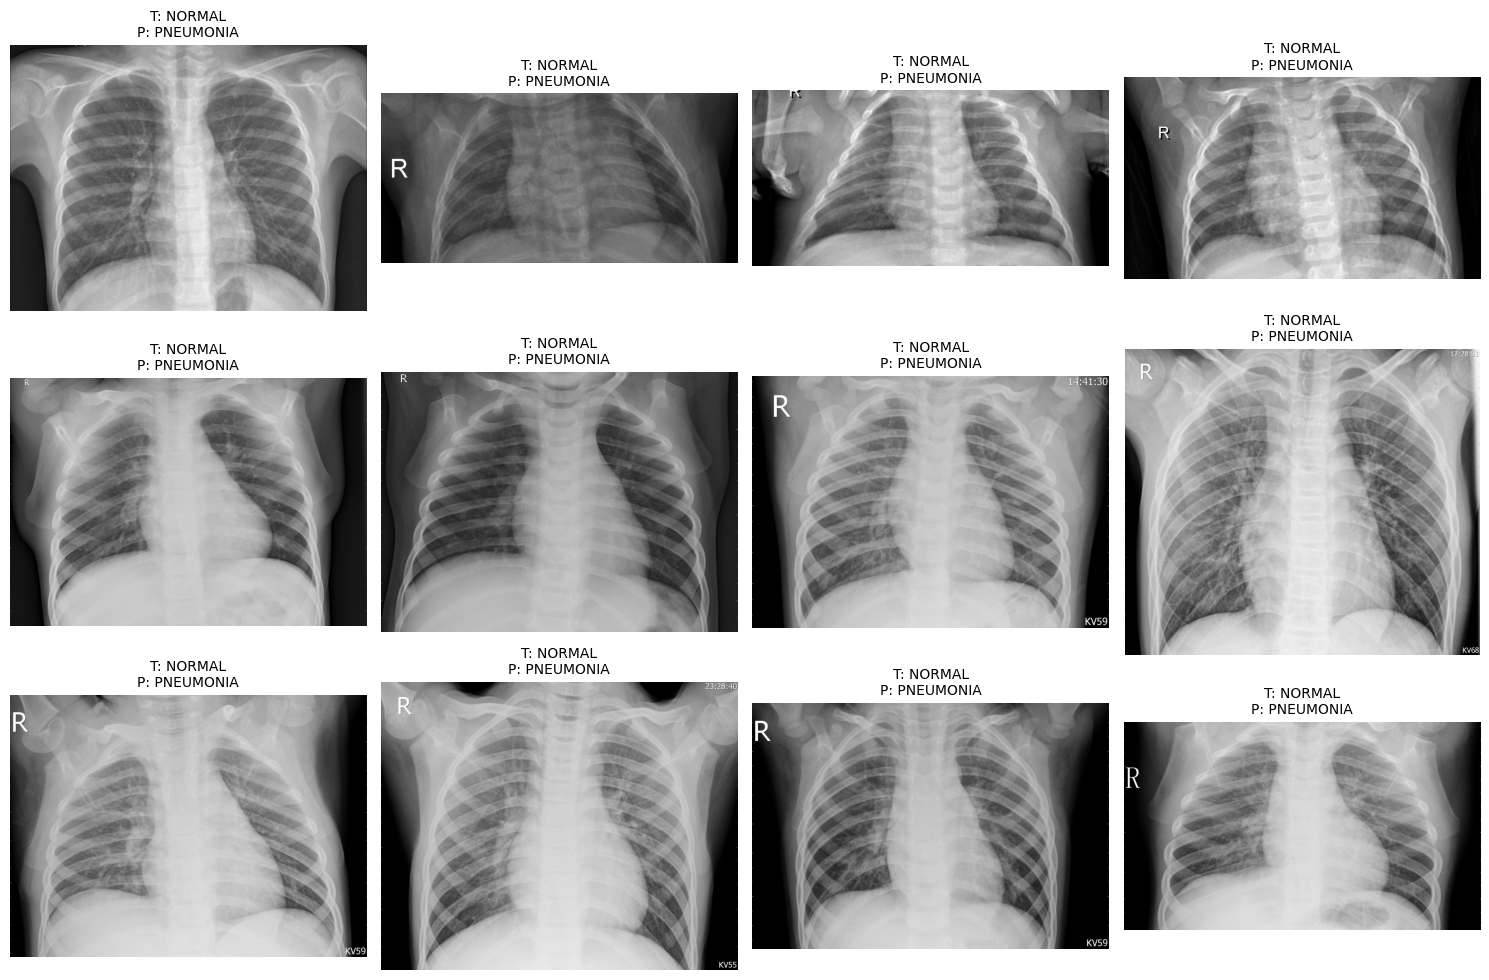

In [77]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# ✅ Step 1: Predict probabilities and get labels
y_probs = model.predict(test_gen)
y_true = test_gen.classes
filepaths = test_gen.filepaths

# ✅ Step 2: Apply fixed threshold = 0.90
threshold = 0.90
print(f"\n🔧 Using Fixed Threshold = {threshold:.2f}")
y_pred = (y_probs > threshold).astype(int).reshape(-1)

# ✅ Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Threshold = 0.90)")
plt.grid(False)
plt.show()

# ✅ Step 4: Performance Metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) else 0
recall = TP / (TP + FN) if (TP + FN) else 0
specificity = TN / (TN + FP) if (TN + FP) else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
auc = roc_auc_score(y_true, y_probs)

print("🔢 Confusion Matrix Counts:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

print("\n📊 Performance Metrics (Threshold = 0.90):")
print(f"Accuracy    : {accuracy:.4f}")
print(f"Precision   : {precision:.4f}")
print(f"Recall      : {recall:.4f}")
print(f"Specificity : {specificity:.4f}")
print(f"F1 Score    : {f1:.4f}")
print(f"AUC         : {auc:.4f}")

# ✅ Step 5: Training Summary
last_epoch = len(history.history['accuracy']) - 1
train_acc = history.history['accuracy'][last_epoch]
val_acc = history.history['val_accuracy'][last_epoch]

print("\n📈 Training Summary (Last Epoch):")
print(f"Training Accuracy   : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")

# ✅ Step 6: ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend()
plt.show()

# ✅ Step 7: Show Misclassified Images
misclassified_idxs = np.where(y_pred != y_true)[0]

print(f"\n🖼️ Showing {min(12, len(misclassified_idxs))} misclassified images:")

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idxs[:12]):
    img = Image.open(filepaths[idx])
    plt.subplot(3, 4, i + 1)
    plt.imshow(img, cmap='gray')
    true_label = 'PNEUMONIA' if y_true[idx] == 1 else 'NORMAL'
    pred_label = 'PNEUMONIA' if y_pred[idx] == 1 else 'NORMAL'
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


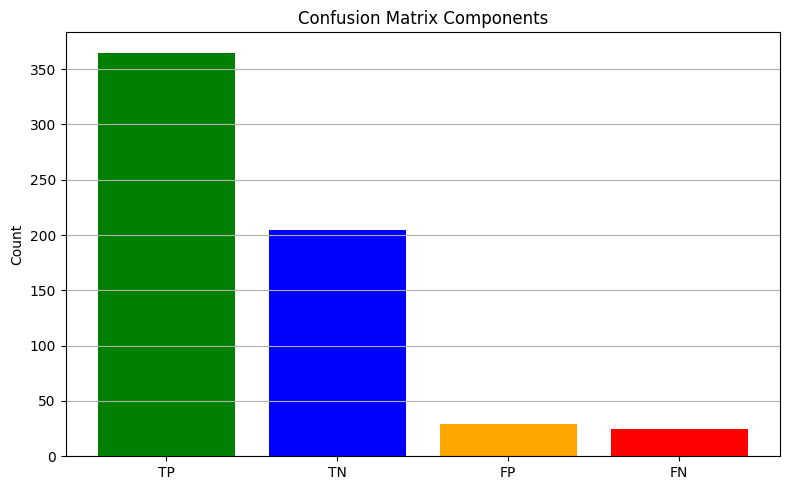

In [78]:
# Optional: Show all CM counts
labels = ['TP', 'TN', 'FP', 'FN']
counts = [TP, TN, FP, FN]
colors = ['green', 'blue', 'orange', 'red']

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=colors)
plt.title('Confusion Matrix Components')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
